# Find population of a US CITY based on
    
    ALAND
    AWATER
    LAT
    LONG
    STATE
    UAtype


steps to train a DNN¶
1. Prepare data
_ clean data
_ vectorize/encode data
_ split data in train,validation and test data
2. Train model
_ create model and layers
_ compile mode(optimizer , metrics, loss)
_ fit model(train data, validation data, epochs, mini batch size)
3. Validate model
_ validate on test data
4. Repeat


In [3]:
import pandas as pd
import numpy as np


In [4]:
#prepare data
city_data = []
#00037	Abbeville, LA Urban Cluster	C	19824	8460	29222871	300497	      11.283	       0.116	 29.967602	 -92.098219  
def parseline(line):
    parts = line.split('\t')
    data={}
    namepart = parts[1].split(',')
    data['NAME']=namepart[0]
    data['STATE']=namepart[1].strip().split()[0].strip()
    data['UAtype']=parts[2]
    data['POP10']= int(parts[3])
    data['ALAND']= int(parts[5])
    data['AWATER']= int(parts[6])
    data['LAT']=float(parts[9])
    data['LONG']=float(parts[10])
    return data
with open('Gaz_ua_national.txt','r') as file:
    city_data = [ parseline(line.strip()) for line in file.readlines()[1:]]

In [5]:
city_data[-1]

{'NAME': 'Zuni Pueblo',
 'STATE': 'NM',
 'UAtype': 'C',
 'POP10': 6744,
 'ALAND': 11876813,
 'AWATER': 0,
 'LAT': 35.071062,
 'LONG': -108.823725}

In [6]:
len(city_data)

3592

In [7]:
df = pd.DataFrame(city_data)
df = df.sample(len(df))#shuffle
df.head()

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype
1407,47328615,111296,36.316527,-78.402573,Henderson,20858,NC,C
2746,69506203,0,26.375238,-98.850736,Rio Grande City--Roma,46344,TX,C
3030,18828106,635980,60.483065,-151.112812,Soldotna,6526,AK,C
268,6026714,14520,43.971548,-88.945505,Berlin,4891,WI,C
1842,229135352,2948709,40.807124,-96.680368,Lincoln,258719,NE,U


In [8]:
def to_numerical(labels):
    numerical_dict={}
    for label in labels:
        if label not in numerical_dict:
            numerical_dict[label]=len(numerical_dict)
    return numerical_dict

def to_one_hot(labels):
    numerical = to_numerical(labels)
    one_hot = np.zeros((len(labels),len(numerical)))
    for i,label in enumerate(labels):
        one_hot[i,numerical[label]]=1
    return np.asarray(one_hot)

In [9]:
#normalise data
train, validation, test = (0.6,0.2,0.2)
numeric_data = np.asarray(df[['ALAND','AWATER','LAT','LONG']].values)
print(numeric_data[0])
mean=[]
std=[]
def normalize_data(numeric_data,fraction):
    global mean, std
    train_size = int(len(numeric_data)*fraction)
    mean =  numeric_data[:train_size].mean(axis=0)
    std =  numeric_data[:train_size].std(axis=0)
    return (numeric_data - mean)/std
 
numeric_data = normalize_data(numeric_data,train)


[ 4.7328615e+07  1.1129600e+05  3.6316527e+01 -7.8402573e+01]


In [10]:
#encode data
states = to_one_hot(df['STATE'].values)
UA = to_one_hot(df['UAtype'].values)
numeric_data = np.concatenate((numeric_data,states,UA),axis=1)
#merge all data
population = np.asarray(df['POP10'].values).astype(np.float32)/1000#population in thousands
population = population.reshape(len(population),1)
population.min()

2.5

In [11]:
numeric_data.shape

(3592, 158)

In [12]:
#split data
train_f, validation_f, test_f = (0.6,0.2,0.2)
train = int(train_f*len(numeric_data))
validation = int((train_f+validation_f)*len(numeric_data))
print(validation)
x_train,x_validate,x_test = (numeric_data[:train],numeric_data[train:(validation)],numeric_data[validation:])
y_train,y_validate,y_test = (population[:train],population[train:(validation)],population[validation:])

2873


In [13]:
x_train.shape,x_validate.shape,x_test.shape

((2155, 158), (718, 158), (719, 158))

In [14]:
from keras import Sequential
from keras import layers
from keras import models
from keras import losses
from keras import optimizers
from keras import metrics

def createmodel(nodes,layers=2):
    model = Sequential()
    model.add(layers.Dense(nodes,activation='relu',input_shape=(x_train.shape[1],)))
    for layer in range(layers-1):
        model.add(layers.Dense(nodes,activation='relu'))
    model.add(layers.Dense(1))#no activation
    
    model.compile(optimizer='rmsprop',loss=['mse'],metrics=['mae'])
    return model

Using TensorFlow backend.


In [30]:
import matplotlib.pyplot as pp
%matplotlib inline
def plothistory(history):
    pp.figure(figsize=(14,4))
    pp.subplot(1,2,1)
    pp.plot(history.history['loss'],label='Training loss')
    pp.plot(history.history['val_loss'],label='Validation loss')
    pp.xlabel('epochs')
    pp.ylabel('loss')
    pp.legend()
    pp.title('Loss vs epoch')
    
    pp.subplot(1,2,2)
    pp.plot(history.history['mean_absolute_error'],label='mean absolute error')
    pp.plot(history.history['val_mean_absolute_error'],label='validation mean absolute error')
    pp.xlabel('epochs')
    pp.ylabel('mae')
    pp.legend()
    pp.title('Mean absolute error vs epoch')

In [20]:
model = createmodel(64)
history = model.fit(x_train,y_train,
         validation_data=(x_validate,y_validate),
         epochs=500,
         batch_size = 50)

Train on 2155 samples, validate on 718 samples
Epoch 1/500
2155/2155 [==============================] - 0s 225us/step - loss: 371879.9690 - mean_absolute_error: 82.0164 - val_loss: 104360.8896 - val_mean_absolute_error: 62.3551
Epoch 2/500
2155/2155 [==============================] - 0s 58us/step - loss: 370657.3279 - mean_absolute_error: 79.8505 - val_loss: 103568.5948 - val_mean_absolute_error: 60.6540
Epoch 3/500
2155/2155 [==============================] - ETA: 0s - loss: 454664.7094 - mean_absolute_error: 86.873 - 0s 58us/step - loss: 369015.4670 - mean_absolute_error: 78.7361 - val_loss: 102444.2330 - val_mean_absolute_error: 60.7174
Epoch 4/500
2155/2155 [==============================] - 0s 65us/step - loss: 366397.6104 - mean_absolute_error: 78.7738 - val_loss: 100720.6593 - val_mean_absolute_error: 61.1420
Epoch 5/500
2155/2155 [==============================] - 0s 80us/step - loss: 360893.5446 - mean_absolute_error: 78.8098 - val_loss: 97706.5373 - val_mean_absolute_error: 6

Epoch 46/500
2155/2155 [==============================] - 0s 58us/step - loss: 57218.7991 - mean_absolute_error: 34.9399 - val_loss: 24679.1061 - val_mean_absolute_error: 31.5183
Epoch 47/500
2155/2155 [==============================] - 0s 101us/step - loss: 56611.6200 - mean_absolute_error: 34.4372 - val_loss: 25066.6305 - val_mean_absolute_error: 31.5808
Epoch 48/500
2155/2155 [==============================] - 0s 73us/step - loss: 54506.5822 - mean_absolute_error: 34.3045 - val_loss: 25842.5124 - val_mean_absolute_error: 31.5696
Epoch 49/500
2155/2155 [==============================] - 0s 58us/step - loss: 54130.2487 - mean_absolute_error: 33.7691 - val_loss: 25816.6994 - val_mean_absolute_error: 31.3278
Epoch 50/500
2155/2155 [==============================] - 0s 160us/step - loss: 52967.9535 - mean_absolute_error: 33.6851 - val_loss: 27403.8002 - val_mean_absolute_error: 31.9974
Epoch 51/500
2155/2155 [==============================] - 1s 248us/step - loss: 52135.3736 - mean_absol

Epoch 92/500
2155/2155 [==============================] - 0s 53us/step - loss: 40136.9623 - mean_absolute_error: 27.4924 - val_loss: 21404.8172 - val_mean_absolute_error: 27.6999
Epoch 93/500
2155/2155 [==============================] - 0s 39us/step - loss: 40665.3738 - mean_absolute_error: 27.2622 - val_loss: 21167.2163 - val_mean_absolute_error: 27.6665
Epoch 94/500
2155/2155 [==============================] - 0s 43us/step - loss: 39468.2413 - mean_absolute_error: 27.0169 - val_loss: 19011.4383 - val_mean_absolute_error: 26.1720
Epoch 95/500
2155/2155 [==============================] - 0s 44us/step - loss: 40125.5309 - mean_absolute_error: 26.8649 - val_loss: 19195.9554 - val_mean_absolute_error: 26.3282
Epoch 96/500
2155/2155 [==============================] - 0s 58us/step - loss: 41642.9050 - mean_absolute_error: 27.1025 - val_loss: 18579.4494 - val_mean_absolute_error: 26.2417
Epoch 97/500
2155/2155 [==============================] - 0s 51us/step - loss: 40408.5987 - mean_absolute

2155/2155 [==============================] - 0s 87us/step - loss: 36754.0787 - mean_absolute_error: 23.1031 - val_loss: 13893.1718 - val_mean_absolute_error: 21.0331
Epoch 138/500
2155/2155 [==============================] - 0s 73us/step - loss: 37068.9348 - mean_absolute_error: 23.1201 - val_loss: 15146.5027 - val_mean_absolute_error: 22.0745
Epoch 139/500
2155/2155 [==============================] - 0s 145us/step - loss: 36355.8744 - mean_absolute_error: 23.0967 - val_loss: 16254.1323 - val_mean_absolute_error: 22.6809
Epoch 140/500
2155/2155 [==============================] - 0s 127us/step - loss: 35176.2767 - mean_absolute_error: 23.0975 - val_loss: 15436.1220 - val_mean_absolute_error: 21.6820
Epoch 141/500
2155/2155 [==============================] - 0s 169us/step - loss: 36446.2544 - mean_absolute_error: 22.8070 - val_loss: 15673.2004 - val_mean_absolute_error: 22.0380
Epoch 142/500
2155/2155 [==============================] - 0s 105us/step - loss: 35746.6004 - mean_absolute_err

2155/2155 [==============================] - 0s 128us/step - loss: 33706.5379 - mean_absolute_error: 20.4949 - val_loss: 14348.9174 - val_mean_absolute_error: 19.9419
Epoch 183/500
2155/2155 [==============================] - 0s 73us/step - loss: 33524.3324 - mean_absolute_error: 20.3346 - val_loss: 13555.5912 - val_mean_absolute_error: 19.4023
Epoch 184/500
2155/2155 [==============================] - 0s 60us/step - loss: 33902.3954 - mean_absolute_error: 20.6754 - val_loss: 14638.1156 - val_mean_absolute_error: 21.2837
Epoch 185/500
2155/2155 [==============================] - 0s 51us/step - loss: 32145.0528 - mean_absolute_error: 20.6735 - val_loss: 16822.5779 - val_mean_absolute_error: 22.0613
Epoch 186/500
2155/2155 [==============================] - 0s 44us/step - loss: 32887.0817 - mean_absolute_error: 20.5521 - val_loss: 16431.0277 - val_mean_absolute_error: 21.0315
Epoch 187/500
2155/2155 [==============================] - 0s 70us/step - loss: 33435.6201 - mean_absolute_error:

2155/2155 [==============================] - 0s 51us/step - loss: 31231.4111 - mean_absolute_error: 19.3998 - val_loss: 13572.6252 - val_mean_absolute_error: 19.2110
Epoch 228/500
2155/2155 [==============================] - 0s 51us/step - loss: 31443.1370 - mean_absolute_error: 19.0624 - val_loss: 14424.9527 - val_mean_absolute_error: 20.1014
Epoch 229/500
2155/2155 [==============================] - 0s 58us/step - loss: 30148.7195 - mean_absolute_error: 19.0987 - val_loss: 14580.2726 - val_mean_absolute_error: 19.7926
Epoch 230/500
2155/2155 [==============================] - 0s 51us/step - loss: 30868.4691 - mean_absolute_error: 19.1025 - val_loss: 15211.4480 - val_mean_absolute_error: 20.4576
Epoch 231/500
2155/2155 [==============================] - 0s 58us/step - loss: 30931.5410 - mean_absolute_error: 19.1269 - val_loss: 15218.3853 - val_mean_absolute_error: 20.2291
Epoch 232/500
2155/2155 [==============================] - 0s 44us/step - loss: 30556.2284 - mean_absolute_error: 

2155/2155 [==============================] - 0s 58us/step - loss: 28524.1895 - mean_absolute_error: 18.3840 - val_loss: 13910.0111 - val_mean_absolute_error: 19.4729
Epoch 273/500
2155/2155 [==============================] - 0s 51us/step - loss: 27956.3754 - mean_absolute_error: 18.5892 - val_loss: 12540.6778 - val_mean_absolute_error: 18.6649
Epoch 274/500
2155/2155 [==============================] - 0s 65us/step - loss: 29063.3746 - mean_absolute_error: 18.2633 - val_loss: 13132.2317 - val_mean_absolute_error: 19.2118
Epoch 275/500
2155/2155 [==============================] - 0s 140us/step - loss: 28440.0852 - mean_absolute_error: 18.2392 - val_loss: 13795.0857 - val_mean_absolute_error: 19.3189
Epoch 276/500
2155/2155 [==============================] - 0s 53us/step - loss: 28605.3655 - mean_absolute_error: 18.3948 - val_loss: 13961.3259 - val_mean_absolute_error: 19.2736
Epoch 277/500
2155/2155 [==============================] - 0s 51us/step - loss: 28203.9257 - mean_absolute_error:

2155/2155 [==============================] - 0s 132us/step - loss: 27145.3650 - mean_absolute_error: 17.8061 - val_loss: 13235.3724 - val_mean_absolute_error: 19.4361
Epoch 318/500
2155/2155 [==============================] - 0s 159us/step - loss: 26463.0194 - mean_absolute_error: 17.5762 - val_loss: 13291.5212 - val_mean_absolute_error: 19.0323
Epoch 319/500
2155/2155 [==============================] - 0s 203us/step - loss: 26653.2728 - mean_absolute_error: 17.2746 - val_loss: 14451.6327 - val_mean_absolute_error: 20.8338
Epoch 320/500
2155/2155 [==============================] - 0s 80us/step - loss: 25179.8182 - mean_absolute_error: 17.4183 - val_loss: 14005.4116 - val_mean_absolute_error: 19.2758
Epoch 321/500
2155/2155 [==============================] - 0s 139us/step - loss: 26197.2434 - mean_absolute_error: 17.2553 - val_loss: 14948.6978 - val_mean_absolute_error: 19.9061
Epoch 322/500
2155/2155 [==============================] - 0s 186us/step - loss: 26391.7404 - mean_absolute_er

2155/2155 [==============================] - 0s 141us/step - loss: 24451.5037 - mean_absolute_error: 16.7149 - val_loss: 15608.3995 - val_mean_absolute_error: 20.0612
Epoch 363/500
2155/2155 [==============================] - 0s 146us/step - loss: 24179.8433 - mean_absolute_error: 16.5131 - val_loss: 15809.5260 - val_mean_absolute_error: 20.0181
Epoch 364/500
2155/2155 [==============================] - 0s 121us/step - loss: 24205.5393 - mean_absolute_error: 16.4879 - val_loss: 15217.4333 - val_mean_absolute_error: 19.8631
Epoch 365/500
2155/2155 [==============================] - 0s 105us/step - loss: 23953.5470 - mean_absolute_error: 16.5792 - val_loss: 15240.3938 - val_mean_absolute_error: 19.7567
Epoch 366/500
2155/2155 [==============================] - 0s 223us/step - loss: 24614.7919 - mean_absolute_error: 17.2126 - val_loss: 14300.7295 - val_mean_absolute_error: 20.2918
Epoch 367/500
2155/2155 [==============================] - 0s 131us/step - loss: 24220.3793 - mean_absolute_e

2155/2155 [==============================] - 0s 85us/step - loss: 22243.2723 - mean_absolute_error: 15.8950 - val_loss: 15218.1591 - val_mean_absolute_error: 20.4619
Epoch 408/500
2155/2155 [==============================] - 0s 129us/step - loss: 21941.8876 - mean_absolute_error: 15.8837 - val_loss: 13933.1580 - val_mean_absolute_error: 19.3808
Epoch 409/500
2155/2155 [==============================] - 0s 152us/step - loss: 21887.2946 - mean_absolute_error: 15.6932 - val_loss: 13959.3900 - val_mean_absolute_error: 19.5785
Epoch 410/500
2155/2155 [==============================] - 0s 116us/step - loss: 22364.9504 - mean_absolute_error: 15.8926 - val_loss: 13968.7496 - val_mean_absolute_error: 19.3726
Epoch 411/500
2155/2155 [==============================] - 0s 114us/step - loss: 21920.1566 - mean_absolute_error: 16.5174 - val_loss: 14447.3348 - val_mean_absolute_error: 20.1421
Epoch 412/500
2155/2155 [==============================] - 0s 123us/step - loss: 21780.9900 - mean_absolute_er

2155/2155 [==============================] - 0s 146us/step - loss: 20029.8729 - mean_absolute_error: 15.5520 - val_loss: 12347.4956 - val_mean_absolute_error: 19.0900
Epoch 453/500
2155/2155 [==============================] - 0s 126us/step - loss: 20156.2572 - mean_absolute_error: 15.4798 - val_loss: 12525.3577 - val_mean_absolute_error: 18.8397
Epoch 454/500
2155/2155 [==============================] - 0s 87us/step - loss: 19400.5677 - mean_absolute_error: 14.9351 - val_loss: 11337.5414 - val_mean_absolute_error: 18.4005
Epoch 455/500
2155/2155 [==============================] - 0s 170us/step - loss: 20093.3266 - mean_absolute_error: 15.5039 - val_loss: 13032.8613 - val_mean_absolute_error: 19.3347
Epoch 456/500
2155/2155 [==============================] - 0s 125us/step - loss: 19501.9885 - mean_absolute_error: 15.6575 - val_loss: 14751.2319 - val_mean_absolute_error: 20.1870
Epoch 457/500
2155/2155 [==============================] - 0s 55us/step - loss: 19824.9975 - mean_absolute_err

2155/2155 [==============================] - 0s 134us/step - loss: 18410.1680 - mean_absolute_error: 14.4126 - val_loss: 12600.0795 - val_mean_absolute_error: 18.8794
Epoch 498/500
2155/2155 [==============================] - 0s 136us/step - loss: 18492.1245 - mean_absolute_error: 14.6037 - val_loss: 13264.1107 - val_mean_absolute_error: 19.1777
Epoch 499/500
2155/2155 [==============================] - 0s 130us/step - loss: 18412.8449 - mean_absolute_error: 14.6895 - val_loss: 13633.6553 - val_mean_absolute_error: 20.1436
Epoch 500/500
2155/2155 [==============================] - 0s 42us/step - loss: 18183.1051 - mean_absolute_error: 14.5113 - val_loss: 13132.6278 - val_mean_absolute_error: 19.0126


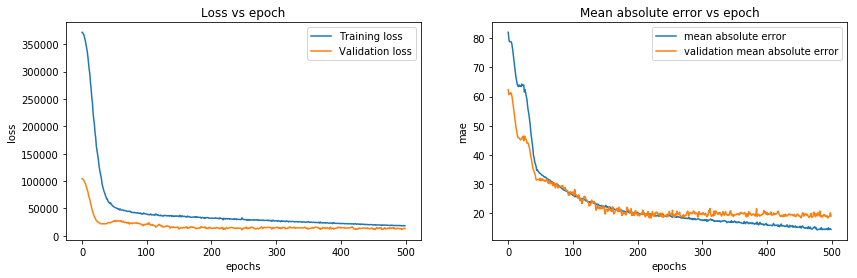

In [31]:
plothistory(history)

In [77]:
def seepredictions(model):
    df_validation = df.loc[df.index[range(train,validation)]].copy()
    #df.tail(len(df)-train).head(validation) #this should work too
    pred = model.predict(x_validate)*1000
    df_validation['Predictions']=pred
    df_validation['DiffPercentage']=abs(df_validation['Predictions']-df_validation['POP10'])/df_validation['POP10']*100
    return df_validation

In [85]:
print('mean percentage diff = ', seepredictions(model)['DiffPercentage'].mean())
val_df = seepredictions(model)
val_df.head()

mean percentage diff =  54.70462832205165


,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,DiffPercentage
263,11685854,791123,32.658272,-93.714164,Benton,5371,LA,C,4759.348145,11.388044
2094,116217257,3754984,43.616301,-84.219878,Midland,59014,MI,U,80515.070312,36.433847
2329,3137704,58464,41.118992,-80.330891,New Wilmington,2638,PA,C,8708.826172,230.129878
787,19619776,55255,38.467905,-78.003223,Culpeper,17778,VA,C,6831.859863,61.571269
692,6983453,26580,33.169471,-86.608767,Columbiana,2642,AL,C,2130.140625,19.373935


In [96]:
#analyze
l = len(val_df)
val_df.sort_values('Predictions').tail(1000).head()

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,DiffPercentage
682,13867750,20502,36.984137,-112.972901,Colorado City,8233,AZ--UT,C,-14331.822266,274.077763
62,4934771,16517,41.489183,-120.546287,Alturas,2910,CA,C,-7184.937500,346.905069
274,6273366,149315,60.794920,-161.782459,Bethel,4434,AK,C,-4541.787109,202.430923
1004,13383580,20221,39.723091,-77.360660,Emmitsburg,6366,MD--PA,C,-1972.281250,130.981484
194,2751283,1094,30.796199,-97.433073,Bartlett,2653,TX,C,-737.884277,127.813203


array([[ 11.735913 ],
       [ 37.788673 ],
       [ -3.8839557],
       ...,
       [493.57593  ],
       [  4.9874234],
       [  3.3945305]], dtype=float32)